In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, f1_score, recall_score, precision_score

In [ ]:
balanced_data = pd.read_parquet('/content/drive/MyDrive/DF-ChurnPrediction/data/balanced_data.parquet')

In [ ]:
balanced_data = balanced_data.drop(['id'], axis=1)

In [ ]:
X = balanced_data.drop(['target'], axis=1)
y = balanced_data['target']

In [ ]:
X.shape

(37074, 705)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
scaler = StandardScaler()

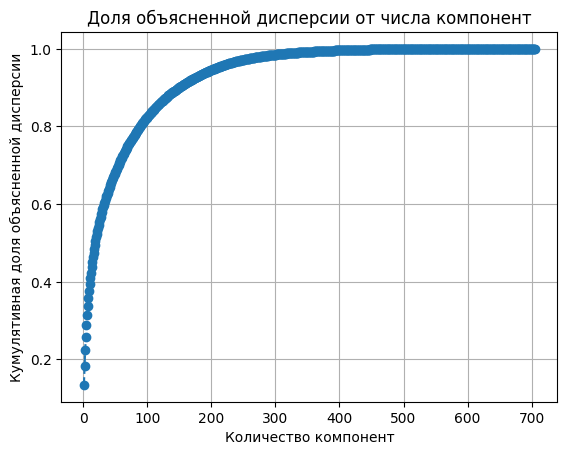

In [ ]:
import matplotlib.pyplot as plt
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

pca = PCA()

X_train_pca = pca.fit(X_train_scaled)

cumulative_explained_variance = pca.explained_variance_ratio_.cumsum()

plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Доля объясненной дисперсии от числа компонент')
plt.xlabel('Количество компонент')
plt.ylabel('Кумулятивная доля объясненной дисперсии')
plt.grid(True)
plt.show()

In [ ]:
optimal_n_components = (cumulative_explained_variance < 0.95).sum() + 1
optimal_n_components

206

In [ ]:
pca_optimal = PCA(n_components=optimal_n_components)

# Примените PCA к обучающему и тестовому наборам данных
X_train_optimal_pca = pca_optimal.fit_transform(X_train_scaled)
X_test_optimal_pca = pca_optimal.transform(X_test_scaled)

In [ ]:
def get_metrics(y_test, y_pred):
  roc_auc = roc_auc_score(y_test, y_pred)
  f1 = f1_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)

  print(f"ROC AUC: {roc_auc}")
  print(f"F1 Score: {f1}")
  print(f"Recall: {recall}")
  print(f"Precision: {precision}")

Логистическая регрессия

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
parameters = {'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
              'penalty':[None, 'elasticnet', 'l1', 'l2'],
              'C':[0.001, 0.01, 0.1, 1, 10, 100]}

log_model = LogisticRegression(random_state=42)
grid_search_clas = GridSearchCV(estimator=log_model, param_grid=parameters, cv=5, scoring='roc_auc')
grid_search_clas.fit(X_train_optimal_pca, y_train)

# Лучшие параметры
best_params_clas = grid_search_clas.best_params_
print(f'Best Hyperparameters: {best_params_clas}')
print(f'ROC AUC: {grid_search_clas.best_score_}')



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

Best Hyperparameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
ROC AUC: 0.7198101048647656


In [ ]:
test_log_model = LogisticRegression(C = 0.001, penalty='l2', solver = 'newton-cg', random_state=42)
test_log_model.fit(X_train_optimal_pca, y_train)
predict = test_log_model.predict(X_test_optimal_pca)
get_metrics(y_test, predict)

ROC AUC: 0.659500446359118
F1 Score: 0.6472286911970191
Recall: 0.6252699784017278
Precision: 0.6707858659972967


In [ ]:
import joblib

joblib.dump(scaler, 'scaler.pkl')

joblib.dump(pca_optimal, 'pca.pkl')


['pca.pkl']

Случайный лес

In [ ]:
parameters = param_grid_random_forest = {
    'n_estimators': [20, 50, 100, 200, 400],
    'max_depth': [None,5, 10, 20, 40],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8, 16],
    'max_features': ['sqrt', 'log2', None],
    'criterion': ['gini', 'entropy', 'log_loss']
}
forest_model = RandomForestClassifier(random_state=42)
grid_search_clas = GridSearchCV(estimator=forest_model, param_grid=parameters, cv=5, scoring='roc_auc')
grid_search_clas.fit(X_train_optimal_pca, y_train)

# Лучшие параметры
best_params_clas = grid_search_clas.best_params_
print(f'Best Hyperparameters: {best_params_clas}')
print(f'ROC AUC: {grid_search_clas.best_score_}')